# Extraction, Cleaning, and Initial Exploratory Data Analysis (EDA) of Data

## Import Packages

In [2]:
# API Requests for data
import requests

# Data Manipulation and Analysis
import pandas as pd
from pprint import pprint 
import json
from io import StringIO

# Database Connection
from sqlalchemy import create_engine

# SQL Querying
from sqlalchemy import inspect, text

#  Plotting and Visualization
from plotnine import *
from plotnine.scales import scale_x_date
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Regressions and Statistics
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# File and System Operations
import os
import sys

## Other Setup

In [3]:
pd.set_option('display.max_columns', None) # Display all columns in any given DataFrame

### Import Custom Packages

In [4]:
# Change the wd
sys.path.insert(0,'../src/')

#Import the packages
from macro_utils import sql_queries as sqlq
from macro_utils import functions as macro

## Connect to the Database

### Finding the correct file directory for the database credentials json with the api key and password


In [5]:
current_dir = os.path.dirname(os.path.abspath("NB01_Extract_Data.ipynb"))
sys.path.insert(0,os.path.join(current_dir, '..'))

credentials_file_path = os.path.join(current_dir, '..', "supabase_credentials.json")

# open the  credentials file and load the data into a variable
with open(credentials_file_path, "r") as f:
    credentials = json.load(f)

#### Connect to the SupaBase Engine

In [6]:
# connect to the database
supabase_engine = sqlq.get_supabase_engine(
    user="postgres",
    password=credentials['password'],
    host=credentials['host'],
    port=5432,
    database="postgres"
)

## Extract Key Data Series

### OECD Data

In [7]:
# Read in the data
oecd_data = pd.read_csv("../data/oecd_gdp_ppp_lf_annual.csv",)

In [8]:
# Select relevant columns of the data
oecd_data = oecd_data.copy()[["REF_AREA", "Reference area", "TIME_PERIOD", "Measure", "OBS_VALUE"]]


In [9]:
# Pivot the data so each Measure becomes a column
oecd_data_long = (
    oecd_data
    .pivot_table(
        index=["REF_AREA", "Reference area", "TIME_PERIOD"],
        columns="Measure",
        values="OBS_VALUE"
    )
    .reset_index()
)

oecd_data_long

Measure,REF_AREA,Reference area,TIME_PERIOD,"Gross domestic product, volume in USD, at constant purchasing power parities",Labour force
0,ARG,Argentina,1993,7.087223e+11,NaN
1,ARG,Argentina,1994,7.500370e+11,NaN
2,ARG,Argentina,1995,7.286969e+11,NaN
3,ARG,Argentina,1996,7.689697e+11,NaN
4,ARG,Argentina,1997,8.313412e+11,NaN
...,...,...,...,...,...
2476,ZAF,South Africa,2022,8.593628e+11,2.337764e+07
2477,ZAF,South Africa,2023,8.653653e+11,2.440128e+07
2478,ZAF,South Africa,2024,8.703832e+11,2.500807e+07
2479,ZAF,South Africa,2025,8.818392e+11,2.508949e+07


In [10]:
# Rename columns to standardized names for easier reference
oecd_data_long = oecd_data_long.rename(columns={
    "REF_AREA": "country_id",
    "Reference area": "country",
    "TIME_PERIOD": "year",
    "Gross domestic product, volume in USD, at constant purchasing power parities": "gdp_ppp",
    "Labour force": "labour_force"
})

# Add a 'date' column representing the last calendar date of each year in datetime format
oecd_data_long['date'] = pd.to_datetime(oecd_data_long['year'].astype(str) + '-12-31')

# Put the date column as second, after the country_id column
oecd_data_long = oecd_data_long[['country_id', 'date', 'country', 'year', 'gdp_ppp', 'labour_force']]

In [11]:
oecd_data_long

Measure,country_id,date,country,year,gdp_ppp,labour_force
0,ARG,1993-12-31,Argentina,1993,7.087223e+11,NaN
1,ARG,1994-12-31,Argentina,1994,7.500370e+11,NaN
2,ARG,1995-12-31,Argentina,1995,7.286969e+11,NaN
3,ARG,1996-12-31,Argentina,1996,7.689697e+11,NaN
4,ARG,1997-12-31,Argentina,1997,8.313412e+11,NaN
...,...,...,...,...,...,...
2476,ZAF,2022-12-31,South Africa,2022,8.593628e+11,2.337764e+07
2477,ZAF,2023-12-31,South Africa,2023,8.653653e+11,2.440128e+07
2478,ZAF,2024-12-31,South Africa,2024,8.703832e+11,2.500807e+07
2479,ZAF,2025-12-31,South Africa,2025,8.818392e+11,2.508949e+07


#### PennWorld Tables Data


In [ ]:
# Read in the PWT Data
pwt=pd.read_excel('../data/pwt1001.xlsx',sheet_name='Data')



In [41]:
# Select only the relevant columns from pwt
pwt = pwt[["countrycode","country", "year", "rgdpo", "pop", "emp","avh","rgdpna","rnna","rtfpna", "delta"]]

# Add a 'date' column representing the last calendar date of each year in datetime format
pwt['date'] = pd.to_datetime(pwt['year'].astype(str) + '-12-31')

In [42]:
pwt

,countrycode,country,year,rgdpo,pop,emp,avh,rgdpna,rnna,rtfpna,delta,date
0,ABW,Aruba,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-12-31
1,ABW,Aruba,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1951-12-31
2,ABW,Aruba,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1952-12-31
3,ABW,Aruba,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1953-12-31
4,ABW,Aruba,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...
12805,ZWE,Zimbabwe,2015,39798.644531,13.814629,6.393752,NaN,42008.199219,53550.226562,1.007705,0.056608,2015-12-31
12806,ZWE,Zimbabwe,2016,40963.191406,14.030331,6.504374,NaN,42325.726562,55167.007812,0.984480,0.058132,2016-12-31
12807,ZWE,Zimbabwe,2017,44316.742188,14.236595,6.611773,NaN,44316.742188,56829.140625,1.000000,0.059470,2017-12-31
12808,ZWE,Zimbabwe,2018,43420.898438,14.438802,6.714952,NaN,46457.097656,58552.808594,1.014160,0.060596,2018-12-31


## Create and use a Function to Dynamically Create a SQL Table

This should automatically detect the columns and types of the data and create a table with the correct column names and types, with only as much data capacity as needed.

In [16]:
def infer_sql_type(series) -> str:
    """
    Infers the appropriate SQL data type for a pandas Series.

    Args:
        series: pd.Series
            The pandas Series for which to infer the SQL type.

    Returns:
        str: The inferred SQL data type as a string.
    """
    # Check if the series is of integer type
    if pd.api.types.is_integer_dtype(series):
        # Infer the minimum required integer size based on the max absolute value
        max_val = series.dropna().abs().max()
        if max_val is None:
            return "INTEGER"  # fallback for empty series
        elif max_val < 2**7:
            return "SMALLINT"  # 8-bit signed
        elif max_val < 2**15:
            return "SMALLINT"  # 16-bit signed
        elif max_val < 2**31:
            return "INTEGER"   # 32-bit signed
        else:
            return "BIGINT"    # 64-bit signed
    # Check if the series is of float type
    elif pd.api.types.is_float_dtype(series):
        return "REAL"
    # Check if the series is of boolean type
    elif pd.api.types.is_bool_dtype(series):
        return "BOOLEAN"
    # Check if the series is of datetime type
    elif pd.api.types.is_datetime64_any_dtype(series):
        return "TIMESTAMP"
    else:
        # For object types, infer VARCHAR length or fallback to TEXT
        max_len = series.dropna().astype(str).map(len).max()
        return f"VARCHAR({max_len})" if max_len else "TEXT"

def df_to_create_table_sql(df: pd.DataFrame, table_name: str) -> str:
    """
    Generates a SQL CREATE TABLE statement based on the columns and types of a pandas DataFrame.

    Args:
        df: pd.DataFrame
            The DataFrame to analyze.
        table_name: str
            The name of the SQL table to create.

    Returns:
        str: The SQL CREATE TABLE statement as a string.
    """
    cols = []
    # Iterate through each column to infer its SQL type and build column definitions
    for col in df.columns:
        sql_type = infer_sql_type(df[col])  # Infer the SQL type for the column
        cols.append(f"{col} {sql_type}")
    # Join all column definitions into a single string
    col_definitions = ",\n    ".join(cols)
    # Add joint primary key constraint for country_id and date
    pk_constraint = "PRIMARY KEY (country_id, date)"
    # Format the final CREATE TABLE SQL statement
    return f"CREATE TABLE IF NOT EXISTS {table_name} (\n    {col_definitions},\n    {pk_constraint}\n);"


### Use this Function to Create the Table


In [17]:
CREATE_TABLE_SQL_QUERY = df_to_create_table_sql(oecd_data_long, "growth_data")
CREATE_TABLE_SQL_QUERY

'CREATE TABLE IF NOT EXISTS growth_data (\n    country_id VARCHAR(4),\n    date TIMESTAMP,\n    country VARCHAR(28),\n    year SMALLINT,\n    gdp_ppp REAL,\n    labour_force REAL,\n    PRIMARY KEY (country_id, date)\n);'

In [18]:
## Drop the table if we wish
with supabase_engine.begin() as connection:
    connection.execute(text("""DROP table IF EXISTS growth_data"""))

In [19]:
## Execute the CREATE TABLE query to create a blank table if it doesn't already exist
with supabase_engine.begin() as connection:
    connection.execute(text(CREATE_TABLE_SQL_QUERY))

In [20]:
# fill in the data into the table
sqlq.make_table(oecd_data_long, "growth_data", supabase_engine)

## Analyse the Data

### Load the Data

In [21]:
# Read the data back from the database
with supabase_engine.begin() as connection:
    plot_data = pd.read_sql(text("""SELECT * FROM growth_data"""), connection)


### Post Database Extraction Data Cleaning

In [22]:
# Sort the data by country and quarter_start for better visualization
plot_data = plot_data.sort_values(by=['country', 'date'])

# Add an indicator column for the gfc and for covid
plot_data['gfc'] = plot_data['date'].between('2008-06-01', '2009-12-31')
plot_data['covid'] = plot_data['date'].between('2019-12-01', '2021-12-31')

### Visualise the different time series for different groupings (countries)

#### Additional Data Cleaning for Plotting Purposes Only

In [23]:
# Convert GDP (PPP) to billions for better readability
plot_data['gdp_ppp'] = plot_data['gdp_ppp'] / 1e9  # Convert to billions

# Convert Labour Force to millions for better readability
plot_data['labour_force'] = plot_data['labour_force'] / 1e6  # Convert to millions

In [24]:
# Calculate min and max date for each aggregate shock period (GFC and COVID)

# Create a list of tuples with period label and corresponding indicator column
periods = [("GFC", "gfc"), ("COVID", "covid")]

# Build the ranges dataframe
shock_ranges = pd.DataFrame([
    {
        "period": label,
        "xmin": plot_data[plot_data[indicator]].date.min(),
        "xmax": plot_data[plot_data[indicator]].date.max()
    }
    for label, indicator in periods
])

# Create a Mapping of period labels to fill colours
shock_fill_mapping = {
    "GFC": "#FFB347",   # orange
    "COVID": "#87CEEB"  # light blue
}

# Check the shock_ranges DataFrame
shock_ranges

,period,xmin,xmax
0,GFC,2008-12-31,2009-12-31
1,COVID,2019-12-31,2021-12-31


#### Setup the Plotting Environment (Colour Mappings, X axis breaks etc)

In [25]:
# Get unique countries
countries = plot_data['country'].unique()
num_countries = len(countries)

# Generate colors from colormap and convert to HEX
cmap = plt.get_cmap('viridis')  
color_palette = [mcolors.to_hex(cmap(i / num_countries)) for i in range(num_countries)]

# Map colors to countries
color_mapping = dict(zip(countries, color_palette))


In [26]:
color_mapping

{'Argentina': '#440154',
 'Australia': '#46085c',
 'Austria': '#471063',
 'Belgium': '#481769',
 'Brazil': '#481d6f',
 'Bulgaria': '#482475',
 'Canada': '#472a7a',
 'Chile': '#46307e',
 'China (People’s Republic of)': '#453781',
 'Colombia': '#433e85',
 'Costa Rica': '#414487',
 'Croatia': '#3e4989',
 'Czechia': '#3c4f8a',
 'Denmark': '#3a548c',
 'Estonia': '#375a8c',
 'Euro area (17 countries)': '#355f8d',
 'Finland': '#32648e',
 'France': '#306a8e',
 'Germany': '#2e6f8e',
 'Greece': '#2c738e',
 'Hungary': '#2a788e',
 'Iceland': '#287d8e',
 'Indonesia': '#26828e',
 'Ireland': '#24868e',
 'Israel': '#228b8d',
 'Italy': '#21918c',
 'Japan': '#1f958b',
 'Korea': '#1f9a8a',
 'Latvia': '#1f9f88',
 'Lithuania': '#20a386',
 'Luxembourg': '#22a884',
 'Mexico': '#26ad81',
 'Netherlands': '#2cb17e',
 'New Zealand': '#32b67a',
 'Norway': '#3bbb75',
 'OECD': '#44bf70',
 'Peru': '#4ec36b',
 'Poland': '#58c765',
 'Portugal': '#63cb5f',
 'Romania': '#6ece58',
 'Russia': '#7ad151',
 'Slovak Republic'

In [27]:
# Create a label mapping for the x axis

# Sort data chronologically and drop duplicates in case of multiple countries
label_df = plot_data[['date', 'year']].drop_duplicates().sort_values('date')

# Choose every 2nd time period (I might change this later)
label_df_filtered = label_df.iloc[::2]

# Extract breaks and labels
yq_breaks = label_df_filtered['date'].tolist()
yq_labels = label_df_filtered['year'].tolist()

### Plot Key Data Series

In [28]:
# Select only a few key countries for illustrative purposes
plot_data = plot_data.copy()[plot_data['country'].isin(['United States', 'Germany', 'Japan'])]

In [29]:
plot_data

,country_id,date,country,year,gdp_ppp,labour_force,gfc,covid
620,DEU,1991-12-31,Germany,1991,3548.92,NaN,False,False
621,DEU,1992-12-31,Germany,1992,3605.62,39.1383,False,False
622,DEU,1993-12-31,Germany,1993,3569.87,39.2233,False,False
623,DEU,1994-12-31,Germany,1994,3664.82,39.2108,False,False
624,DEU,1995-12-31,Germany,1995,3722.78,38.9700,False,False
...,...,...,...,...,...,...,...,...
2409,USA,2022-12-31,United States,2022,24269.70,164.2880,False,False
2410,USA,2023-12-31,United States,2023,24970.50,167.1180,False,False
2411,USA,2024-12-31,United States,2024,25668.70,168.1100,False,False
2412,USA,2025-12-31,United States,2025,26072.50,171.1150,False,False


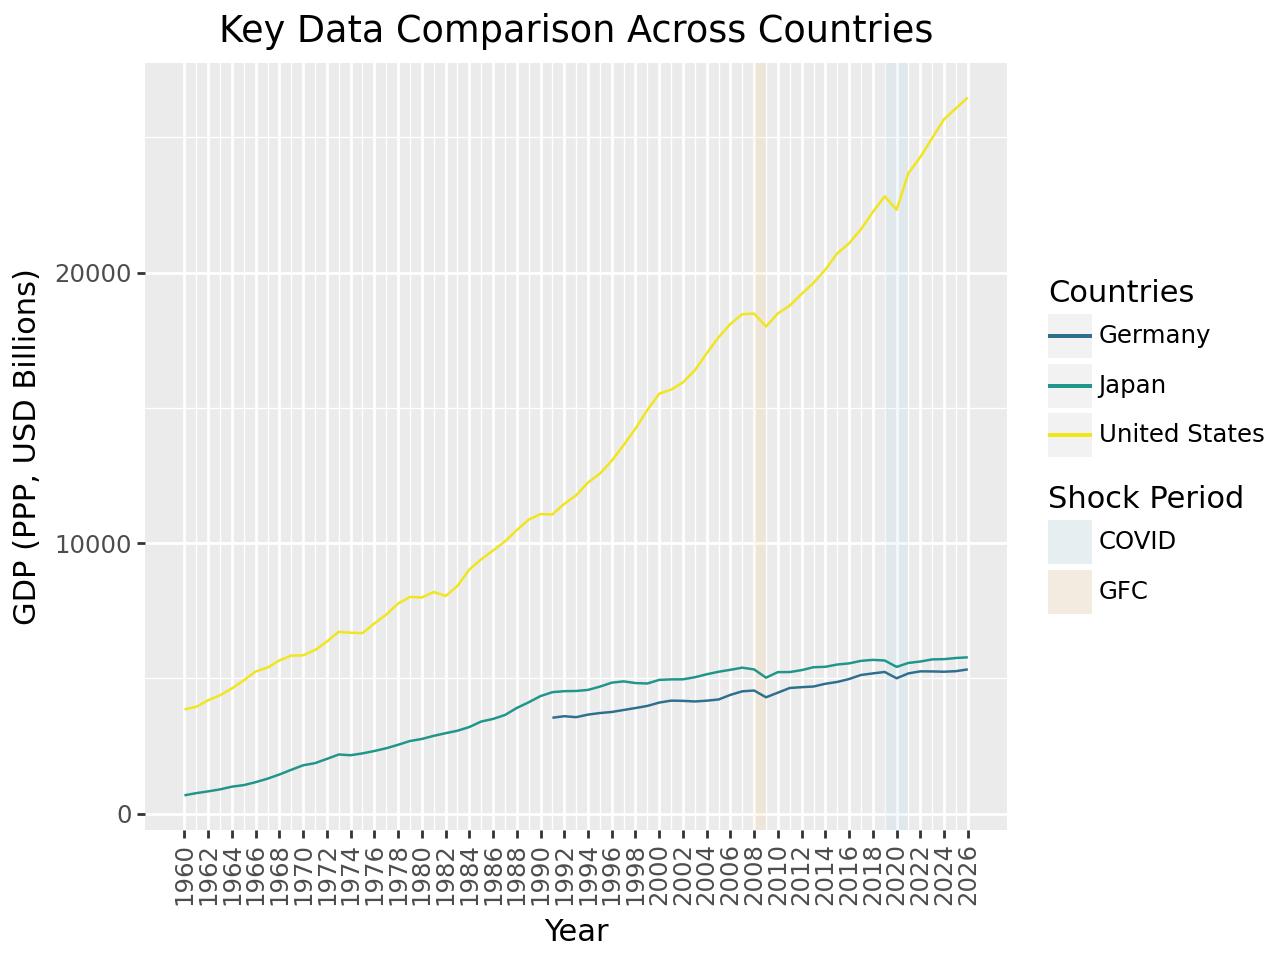

In [30]:
# Create the plot object with plotnine, mapping date to x, gdp_ppp to y, and color by country
g = (
    ggplot(plot_data, aes(x='date', y='gdp_ppp', color='country')) +
    
    # Add shaded rectangles for shock periods (GFC and COVID)
    geom_rect(
        data=shock_ranges,
        inherit_aes=False,
        mapping=aes(
            xmin='xmin',
            xmax='xmax',
            ymin=-float('inf'),
            ymax=float('inf'),
            fill='period'
        ),
        alpha=0.10
    ) +
    
    # Plot GDP PPP time series as lines for each country
    geom_line() +
    
    # Set manual colors for countries
    scale_color_manual(name="Countries", values=color_mapping) +
    
    # Set manual fill colors for shock periods
    scale_fill_manual(name="Shock Period", values=shock_fill_mapping) +
    
    # Set x-axis breaks and labels using filtered years
    scale_x_date(breaks=yq_breaks, labels=yq_labels) +
    
    # Add plot title and axis labels
    labs(
        title='Key Data Comparison Across Countries',
        x='Year',
        y='GDP (PPP, USD Billions)',
        color='Country'
    ) +
    
    # Rotate x-axis text for better readability
    theme(
        axis_text_x=element_text(rotation=90, ha='center')
    ) +
    
    # Remove linetype legend from the plot
    guides(linetype=None)
)
g




In [31]:
# Save the plot to a file
g.save(
    filename="../docs/figures/key_data_comparison.png",
    width=10,
    height=6,
    dpi=300
)

c:\Users\danie\miniconda3\envs\venv-macro\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
c:\Users\danie\miniconda3\envs\venv-macro\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: ../docs/figures/key_data_comparison.png


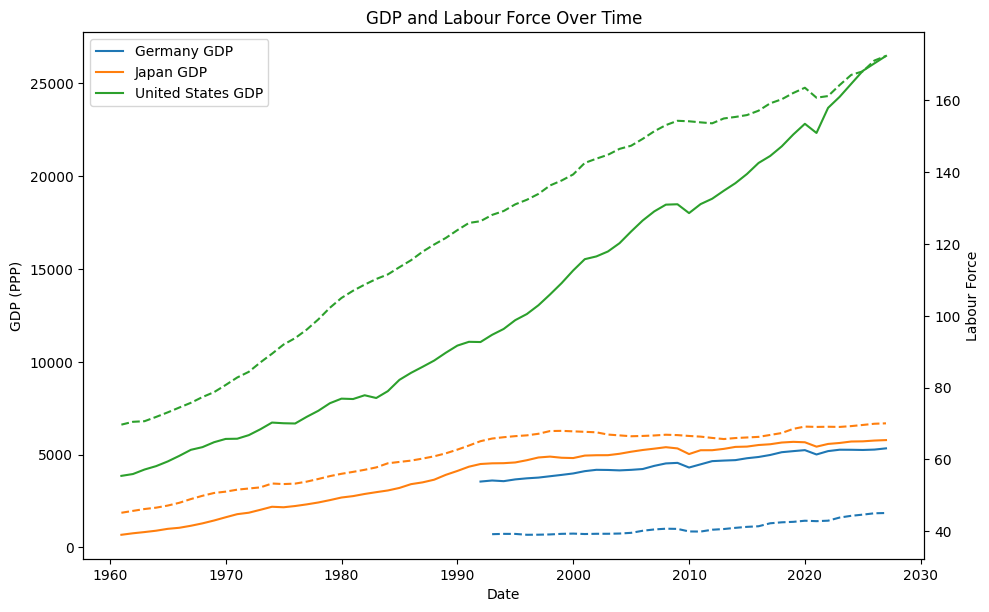

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GDP on the primary y-axis
for country in plot_data['country'].unique():
    country_data = plot_data[plot_data['country'] == country]
    ax1.plot(country_data['date'], country_data['gdp_ppp'], label=f'{country} GDP')

ax1.set_xlabel('Date')
ax1.set_ylabel('GDP (PPP)')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot labor force on the secondary y-axis
for country in plot_data['country'].unique():
    country_data = plot_data[plot_data['country'] == country]
    ax2.plot(country_data['date'], country_data['labour_force'], linestyle='dashed', label=f'{country} Labor Force')

ax2.set_ylabel('Labour Force')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.title("GDP and Labour Force Over Time")
plt.show()